In [1]:
from dataclasses import dataclass
import random
import sys
from collections import OrderedDict
from copy import deepcopy
from typing import Dict, List, OrderedDict, Tuple

import gmsh
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import shapely.affinity
import shapely.geometry
from shapely.ops import unary_union
from shapely.plotting import plot_polygon
from sklearn.cluster import AgglomerativeClustering, KMeans

In [32]:
polygon = shapely.Polygon(((0, 0.0875), (0.025, 0.0875), (0.975, 0.0875), (1, 0.0875), (1, 0.9125), (0.85, 0.9125), (0.6, 0.9125), (0.4, 0.9125), (0.15, 0.9125), (0, 0.9125)))

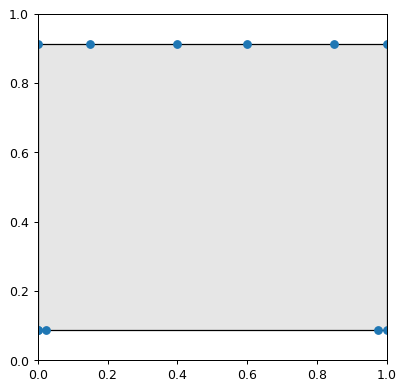

In [33]:
fig = plt.figure(1, figsize=(5, 5), dpi=90)
ax = fig.add_subplot(111)
plot_polygon(polygon, ax, facecolor=(0.9, 0.9, 0.9), edgecolor=(0, 0, 0))
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.show()

In [34]:
def get_geometry_coordinates(
    geometry: shapely.geometry.Polygon,
) -> Tuple[List[List[Tuple[float, float]]], List[Tuple[float, float]]]:
    internal_polygons_coordinates = []
    for polygon in geometry.interiors:
        internal_polygons_coordinates.append(
            polygon.coords[:-1]
        )  # The last point is the same as the first point

    external_polygon_coordinates = geometry.exterior.coords[
        :-1
    ]  # The last point is the same as the first point

    return internal_polygons_coordinates, external_polygon_coordinates

def create_gmsh_polygon(
    coordinates: List[Tuple[float, float]], mesh_size: float
) -> Tuple[List[int], OrderedDict[int, Tuple[int, int]], int]:
    if gmsh.isInitialized() == 0:
        raise Exception("Gmsh is not initialized")

    polygon_ptags = []  # List of tags of points that make up the polygon
    polygon_ltag_ptags = (
        OrderedDict()
    )  # Maps the line tag to the tags of points that make up the line

    for point in coordinates:
        polygon_ptags.append(
            gmsh.model.geo.add_point(point[0], point[1], 0.0, mesh_size)
        )

    for i in range(len(polygon_ptags) - 1):
        polygon_ltag_ptags[
            gmsh.model.geo.add_line(polygon_ptags[i], polygon_ptags[i + 1])
        ] = (polygon_ptags[i], polygon_ptags[i + 1])
    polygon_ltag_ptags[
        gmsh.model.geo.add_line(polygon_ptags[-1], polygon_ptags[0])
    ] = (
        polygon_ptags[-1],
        polygon_ptags[0],
    )  # Close the polygon

    polygon_tag = gmsh.model.geo.add_curve_loop(list(polygon_ltag_ptags.keys()))

    return polygon_ptags, polygon_ltag_ptags, polygon_tag

def generate_mesh(
        geometry: shapely.geometry.Polygon,
        name: str,
        mesh_size: float = 1e-2,
        view_mesh: bool = False,
        filetype: str = "mesh",
    ) -> Tuple[List[List[int]], List[OrderedDict[int, Tuple[int, int]]]]:
        gmsh.initialize()  # Initialize the Gmsh API

        # Get the coordinates of the external and internal polygons
        (
            internal_polygons_coordinates,
            external_polygon_coordinates,
        ) = get_geometry_coordinates(geometry)

        # Create the Gmsh geometry

        internal_polygons_ptags: List[List[int]] = []
        internal_polygons_ltag_ptags: List[OrderedDict[int, Tuple[int, int]]] = []
        internal_polygons_tag: List[int] = []

        # Create the internal polygons
        for coordinates in internal_polygons_coordinates:
            (
                internal_polygon_ptags,
                internal_polygon_ltag_ptags,
                internal_polygon_tag,
            ) = create_gmsh_polygon(coordinates, mesh_size)

            internal_polygons_ptags.append(internal_polygon_ptags)
            internal_polygons_ltag_ptags.append(internal_polygon_ltag_ptags)
            internal_polygons_tag.append(internal_polygon_tag)

        # Create the external polygon
        (
            external_polygon_ptags,
            external_polygon_ltag_ptags,
            external_polygon_tag,
        ) = create_gmsh_polygon(external_polygon_coordinates, mesh_size)

        # Combine the tags of the external and internal polygons
        polygons_ptags = [external_polygon_ptags, *internal_polygons_ptags]
        polygons_ltag_ptags = [
            external_polygon_ltag_ptags,
            *internal_polygons_ltag_ptags,
        ]

        surface_tag = gmsh.model.geo.add_plane_surface(
            [external_polygon_tag, *internal_polygons_tag]
        )  # Create the surface

        gmsh.model.addPhysicalGroup(
            2, [surface_tag], name="surface"
        )  # Add the surface to a physical group

        gmsh.model.geo.synchronize()  # Synchronize the Gmsh model

        gmsh.model.mesh.generate()  # Generate the mesh

        gmsh.write("{}.geo_unrolled".format(name))  # Write the geometry to a file

        mesh_path = "{}.{}".format(name, filetype)
        gmsh.write(mesh_path)  # Write the mesh to a file

        if view_mesh:
            if "close" not in sys.argv:
                gmsh.fltk.run()
        # Close the Gmsh API
        gmsh.finalize()

        return polygons_ptags, polygons_ltag_ptags

In [35]:
ptags, ltags_ptags = generate_mesh(polygon, "test", view_mesh=True)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 80%] Meshing curve 9 (Line)
Info    : [ 90%] Meshing curve 10 (Line)
Info    : Done meshing 1D (Wall 0.00177389s, CPU 0.00204s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.371918s, CPU 0.373331s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.3154e-05s, CPU 1.4e-05s)
Info    : 9838 nodes 19684 elements
Info    : Writing 'test.geo_unrolled'...
Info    : Done writing 'test.geo_unrolled'
Info    : Writing 'test.mesh'...
Info    : Done writing 'test.mesh'
-------------------------------------------------------
Version       : 4.11.1
License       : GNU General Pu

In [36]:
mesh = pv.read("test.mesh")
coords = np.array(mesh.points)

In [40]:
# Select all coordinates with y > 0.6875
concrete_region = coords[coords[:, 1] > 0.6875][:, :2]
steel_region = coords[coords[:, 1] <= 0.6875][:, :2]

In [41]:
print(len(concrete_region), len(steel_region), len(coords), len(concrete_region) + len(steel_region))

2712 7126 9838 9838


In [42]:
print(ptags, ltags_ptags)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]] [OrderedDict([(1, (1, 2)), (2, (2, 3)), (3, (3, 4)), (4, (4, 5)), (5, (5, 6)), (6, (6, 7)), (7, (7, 8)), (8, (8, 9)), (9, (9, 10)), (10, (10, 1))])]


In [44]:
condition = {
                "material_regions": {
                    (30000, 0.2): concrete_region,
                    (210000, 0.3): steel_region,
                },
                "point_constraints": [2, 3],
                "edge_constraints": [],
                "point_forces": [(6, (0, -200)), (7, (0, -200)), (8, (0, -200)), (9, (0, -200))],
                "edge_forces": [],
            }

In [45]:
from datagen.fea_analysis import FEAnalysis
analyzer = FEAnalysis(
                filename="test.mesh",
                data_dir="",
                condition_dir="",
                force_vertex_tags_magnitudes=condition[
                    "point_forces"
                ],
                force_edges_tags_magnitudes=condition["edge_forces"],
                constraints_vertex_tags=condition[
                    "point_constraints"
                ],
                constraints_edges_tags=condition["edge_constraints"],
                material_properties_to_vertices=condition[
                    "material_regions"
                ],
                # youngs_modulus = 210000,
                # poisson_ratio = 0.3,
                num_steps=2,
                save_meshes=True,
            )

sfepy: reading mesh (test.mesh)...
sfepy:   number of vertices: 9838
sfepy:   number of cells:
sfepy:     2_3: 19307
sfepy: ...done in 0.04 s


In [46]:
success = analyzer.calculate()

sfepy: saving regions as groups...
sfepy:   Omega
sfepy:   VertexForce0
sfepy:   VertexForce1
sfepy:   VertexForce2
sfepy:   VertexForce3
sfepy:   VertexConstraint0
sfepy:   VertexConstraint1
sfepy:   MaterialRegion0
sfepy:   MaterialRegion1
sfepy: ...done
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (19672, 19672)
sfepy: assembling matrix graph...
sfepy: ...done in 0.02 s
sfepy: matrix structural nonzeros: 270712 (7.00e-02% fill)
sfepy: ====== time 0.000000e+00 (step 1 of 2) =====
sfepy: updating variables...
sfepy: ...done
sfepy: updating materials...
sfepy:     VertexMagnitude1
sfepy:     VertexMagnitude3
sfepy:     VertexMagnitude0
sfepy:     m
sfepy:     VertexMagnitude2
sfepy:     m
sfepy: ...done in 0.02 s
sfepy: initial residual: 0.000000e+00
sfepy: equation "tmp":
sfepy: ev_cauchy_strain.2.Omega(u)
sfepy: updating materials...
sfepy: ...done in 0.00 s
sfepy: equation "tmp":
sfepy: ev_cauchy_st

In [47]:
import os
from datagen.utils import find_image_bounds, verify_directory

mesh from domain.0.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: node_groups, mat_id
  vectors: u, cauchy_strain, cauchy_stress
  steps:   1
plot 0: None(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


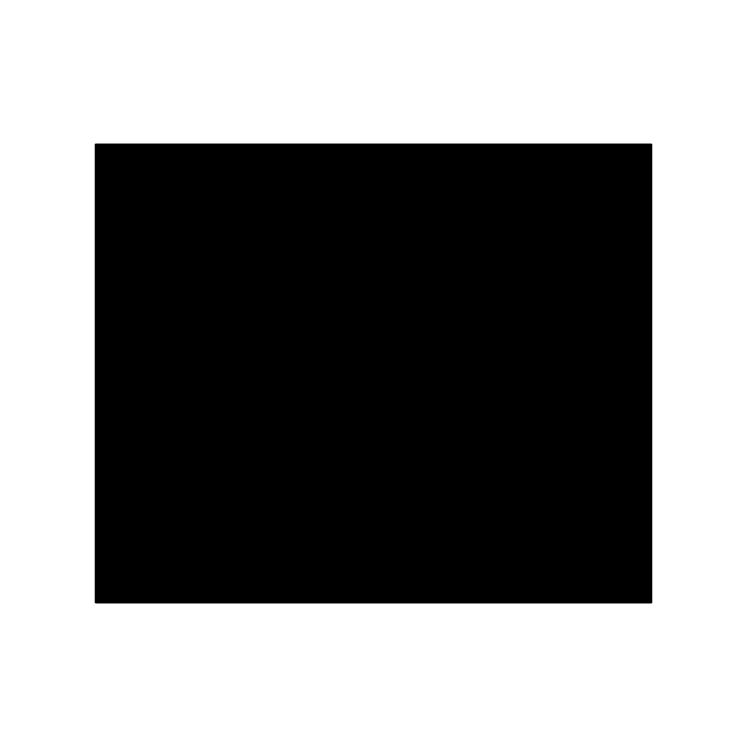

saved: outline.png
mesh from domain.0.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: node_groups, mat_id
  vectors: u, cauchy_strain, cauchy_stress
  steps:   1
plot 0: None(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


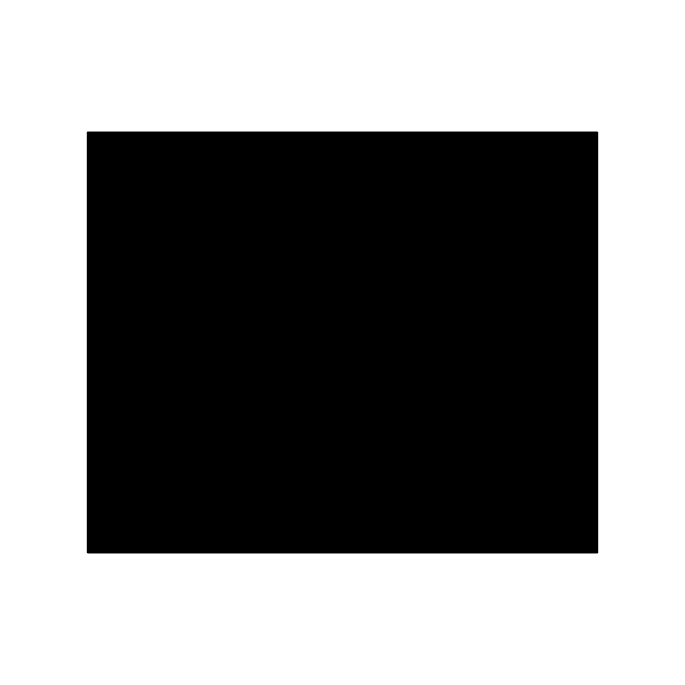

saved: outline.png
mesh from domain.0.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: node_groups, mat_id
  vectors: u, cauchy_strain, cauchy_stress
  steps:   1
plot 0: None(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


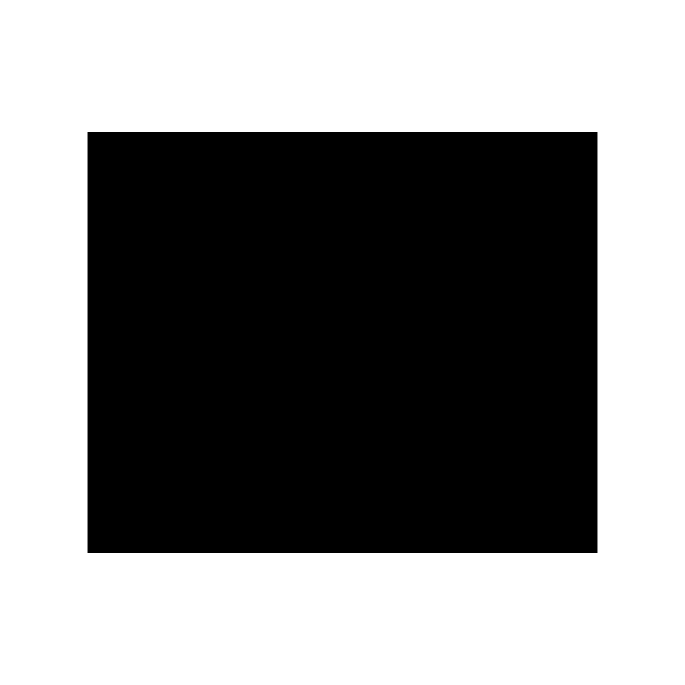

saved: input.png


In [48]:
plate_dir = os.path.join("")
image_size = 512
outline_dir = os.path.join(plate_dir, "outline.png")
analyzer.save_input_image(outline_dir, outline=True, crop=False)
left, top, right, bottom = find_image_bounds(outline_dir)
max_size = max(right - left, bottom - top)
modified_image_size = round(
    image_size / (max_size / analyzer.initial_image_size)
)
analyzer.update_image_size_or_bounds(image_size=modified_image_size)

analyzer.save_input_image(outline_dir, outline=True, crop=False)
left, top, right, bottom = find_image_bounds(outline_dir)
lbound, ubound = (left, right) if right > bottom else (top, bottom)
bounds = (lbound, lbound, ubound, ubound)
analyzer.update_image_size_or_bounds(bounds=bounds)
plate_image_size, plate_bounds = modified_image_size, bounds
analyzer.save_input_image(os.path.join(plate_dir, "input.png"))

mesh from regions.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: Omega, VertexForce0, VertexForce1, VertexForce2, VertexForce3, VertexConstraint0, VertexConstraint1, MaterialRegion0, MaterialRegion1, node_groups, mat_id
  steps:   1
plot 0: VertexForce0(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


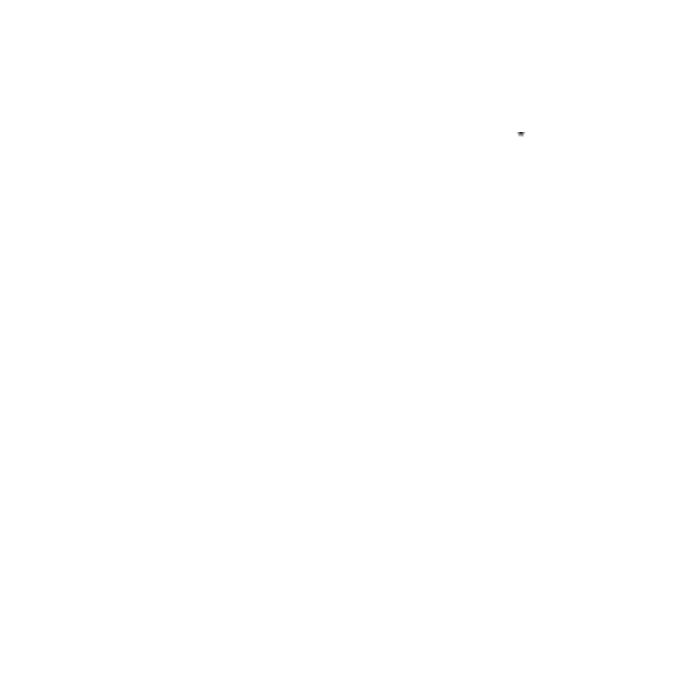

saved: regions_VertexForce0.png
mesh from regions.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: Omega, VertexForce0, VertexForce1, VertexForce2, VertexForce3, VertexConstraint0, VertexConstraint1, MaterialRegion0, MaterialRegion1, node_groups, mat_id
  steps:   1
plot 0: VertexForce1(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


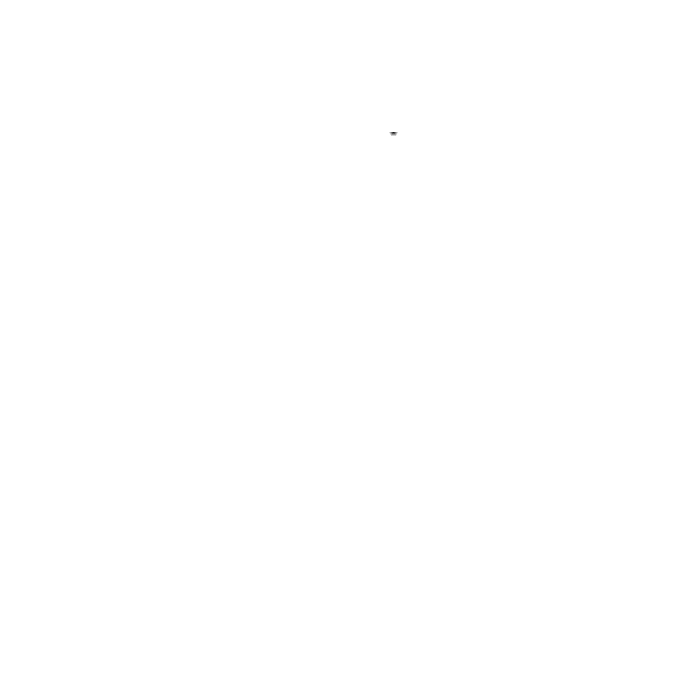

saved: regions_VertexForce1.png
mesh from regions.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: Omega, VertexForce0, VertexForce1, VertexForce2, VertexForce3, VertexConstraint0, VertexConstraint1, MaterialRegion0, MaterialRegion1, node_groups, mat_id
  steps:   1
plot 0: VertexForce2(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


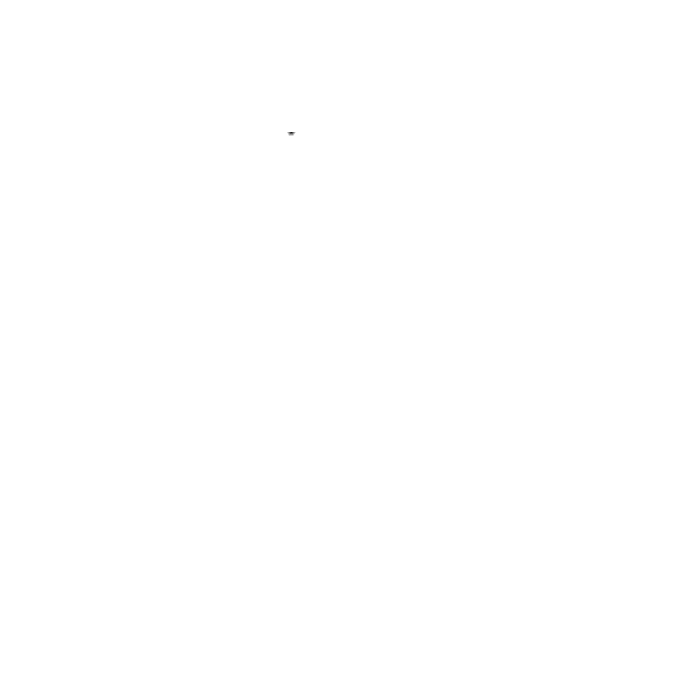

saved: regions_VertexForce2.png
mesh from regions.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: Omega, VertexForce0, VertexForce1, VertexForce2, VertexForce3, VertexConstraint0, VertexConstraint1, MaterialRegion0, MaterialRegion1, node_groups, mat_id
  steps:   1
plot 0: VertexForce3(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


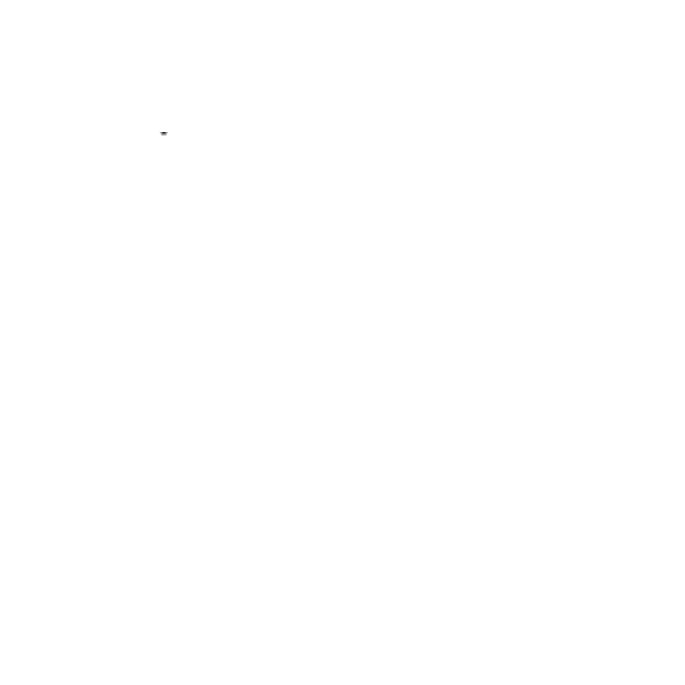

saved: regions_VertexForce3.png
mesh from regions.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: Omega, VertexForce0, VertexForce1, VertexForce2, VertexForce3, VertexConstraint0, VertexConstraint1, MaterialRegion0, MaterialRegion1, node_groups, mat_id
  steps:   1
plot 0: VertexConstraint0(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


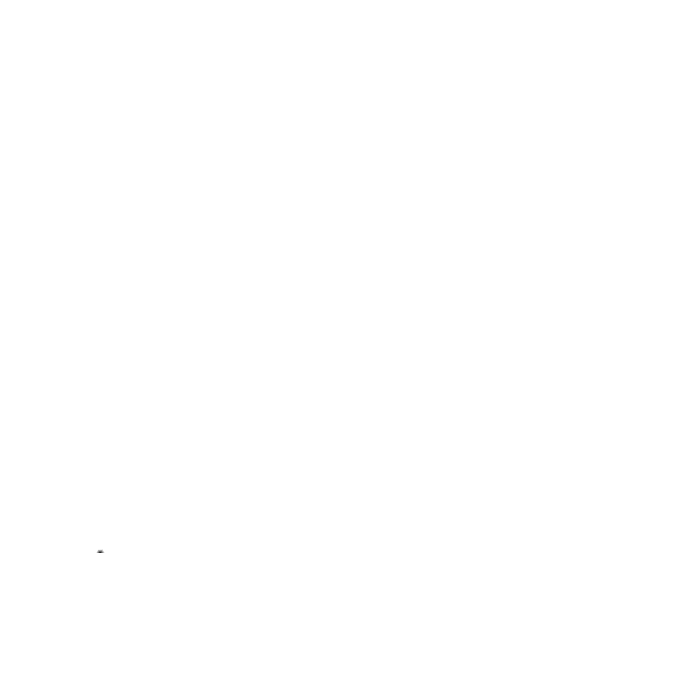

saved: regions_VertexConstraint0.png
mesh from regions.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: Omega, VertexForce0, VertexForce1, VertexForce2, VertexForce3, VertexConstraint0, VertexConstraint1, MaterialRegion0, MaterialRegion1, node_groups, mat_id
  steps:   1
plot 0: VertexConstraint1(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


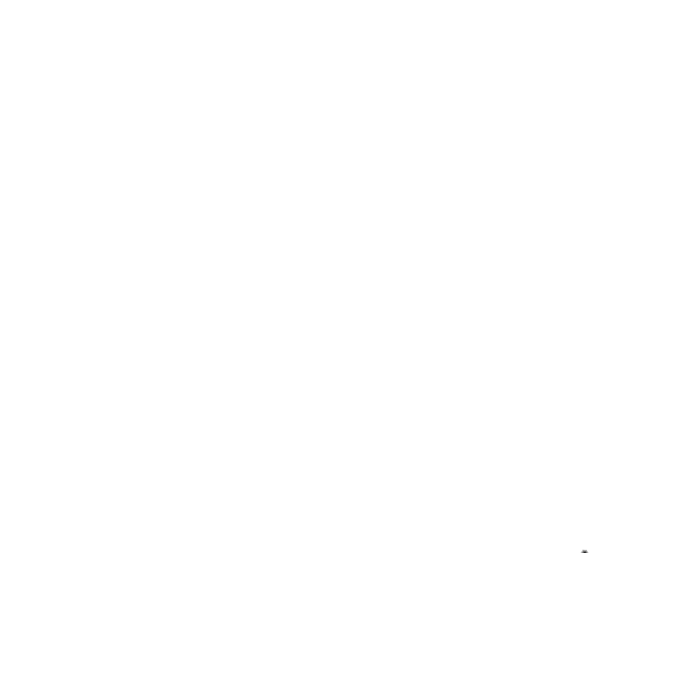

saved: regions_VertexConstraint1.png
mesh from regions.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: Omega, VertexForce0, VertexForce1, VertexForce2, VertexForce3, VertexConstraint0, VertexConstraint1, MaterialRegion0, MaterialRegion1, node_groups, mat_id
  steps:   1
plot 0: MaterialRegion0(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


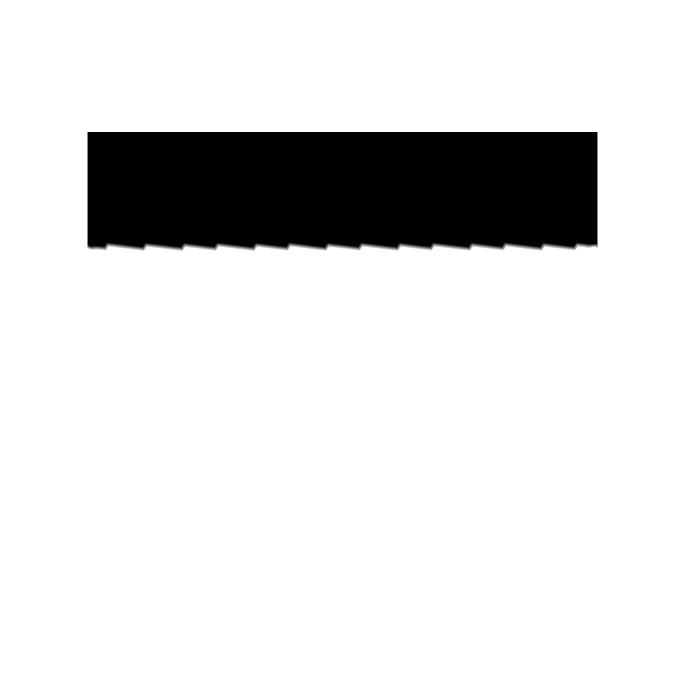

saved: regions_MaterialRegion0.png
mesh from regions.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: Omega, VertexForce0, VertexForce1, VertexForce2, VertexForce3, VertexConstraint0, VertexConstraint1, MaterialRegion0, MaterialRegion1, node_groups, mat_id
  steps:   1
plot 0: MaterialRegion1(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


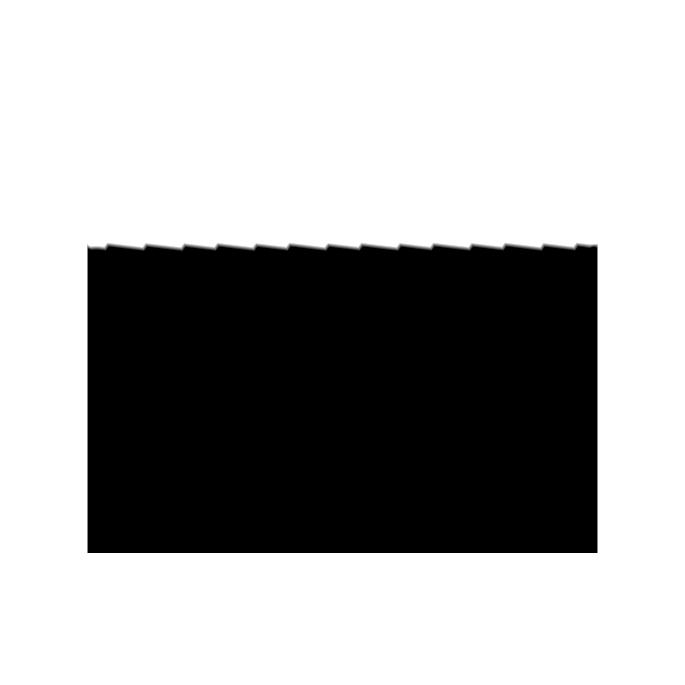

/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


saved: regions_MaterialRegion1.png
mesh from domain.1.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: node_groups, mat_id
  vectors: u, cauchy_strain, cauchy_stress
  steps:   1
plot 0: u_0(step 0)


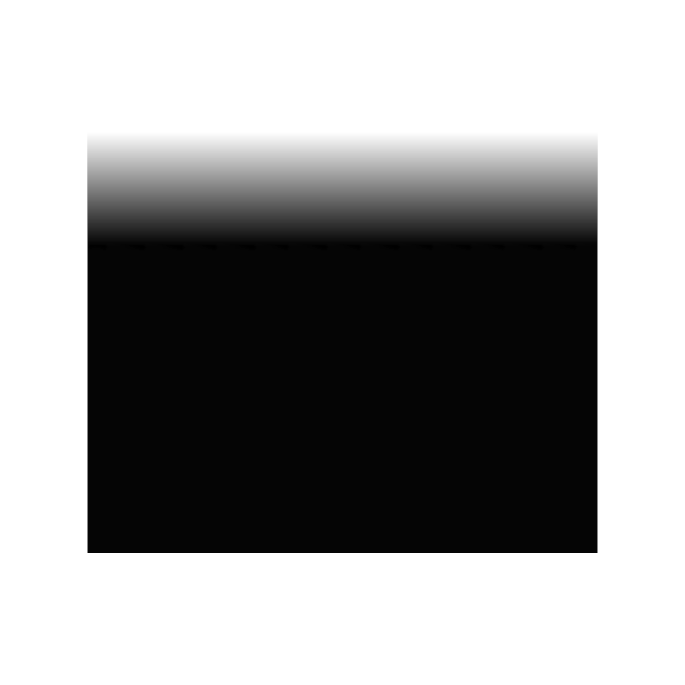

saved: outputs_displacement_x.png
mesh from domain.1.vtk:
  points:  9838
  cells:   19307
  bounds:  [(0.0, 1.0), (0.0875, 0.9125), (0.0, 0.0)]
  scalars: node_groups, mat_id
  vectors: u, cauchy_strain, cauchy_stress
  steps:   1
plot 0: u_1(step 0)


/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


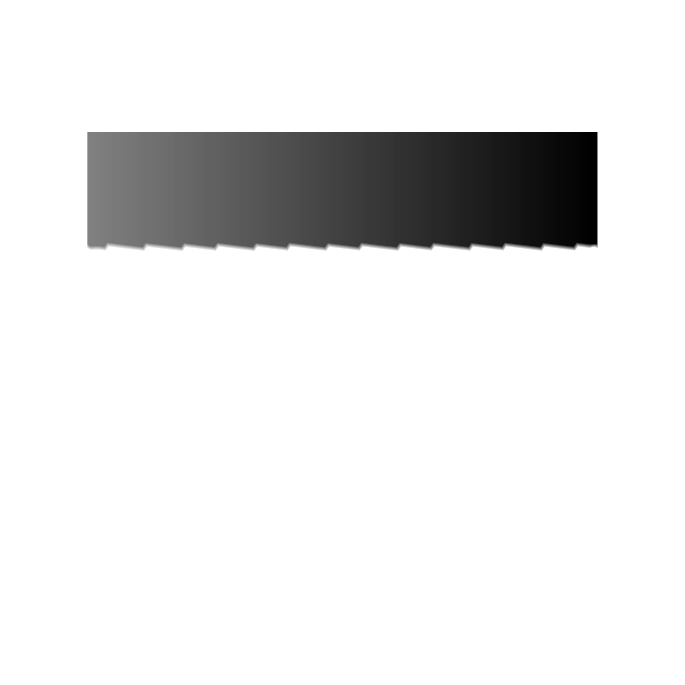

saved: outputs_displacement_y.png


In [49]:
analyzer.save_region_images(os.path.join("regions"))
analyzer.save_output_images(
    os.path.join("outputs"),
    save_displacement=True,
    save_strain=False,
    save_stress=False,
)